In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import scipy.signal as signal
import bitarray

# Analog RF

The physical analog frontend provides gives us a frequency offset input (set by indexing into a LUT) from the carrier for TX modulation. It also mixes the RF signal to form I and Q signals which are sampled by two ADCs.

In [1]:
# Constants
# F_CR  = 2.4e9 # 2.4GHz
F_CR  = 100e6 # lower freq for easier computation, same math
F_DF  = 500e3 # 500kHz deviation
F_IF  = 2e6   # 2MHz
F_ADC = 8e6   # 8Msamples/s (ended up using 32MHz)

FS_CR = 16 * F_CR # oversample for that smoothness

For simulating frequency modulation, we observe that $\frac{d\theta}{dt}=2\pi f(t)$. Since $f(t)=f_{carrier}+\Delta f\cdot s(t)$ where $s(t)$ is the input signal, we can derive $\theta(t)=2\pi\left(f_{carrier}t+\Delta f\int_0^ts(t)dt\right)$. Since $s(t)$ consists of discrete time samples where $s(t)=s[k]$ given $k=t/dt$, $dt=\frac{1}{f_s}$, and $f_s$ is the sampling frequency, we can express $\int_0^ts(t)dt=dt\sum_{i=0}^{t/dt} s[i]$.

In [3]:
def rf_mod(data, fs):
    # Modulates data onto carrier frequency. +1 is F_DF above and -1 is F_DF below. Can do anything in between.
    # For hardware implementation, data will be some n-bit numbers in a LUT.
    
    # TODO discretize the points
    # duplicate points (like a zero-order hold DAC)
    n_samples = int(len(data)*FS_CR/fs)
    data = np.kron(data, np.ones(n_samples//len(data)))
    
    # frequency modulate
    dt = 1/FS_CR
    ts = np.r_[0:n_samples]*dt
    theta = 2*np.pi*F_CR*ts + 2*np.pi*F_DF*(dt*np.cumsum(data))
    ys = np.sin(theta)
    
    # TODO add noise?
    
    return ts, ys

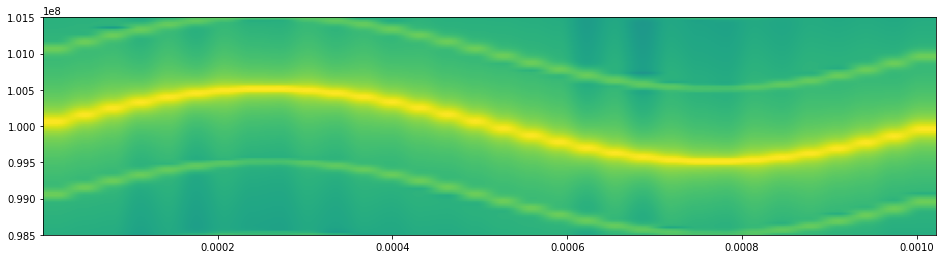

In [4]:
data = np.array(np.sin(2*np.pi*np.linspace(0, 1, num=1024)))
ts, sig = rf_mod(data, 1e6)

plt.figure(figsize=(16,4))
plt.specgram(sig, NFFT=len(sig)//len(data)*32, Fs=FS_CR)
plt.ylim([F_CR-3*F_DF, F_CR+3*F_DF])
plt.show()

For simulating frequency demodulation, we set our LO to $f_{LO}=f_{carrier}-f_{intermediate}$. We generate the I/Q signals by mixing (or multiplying) with $f_{LO}$ (90° shifted for Q). We can also shift our $f_{LO}$ to simulate the phase shift from the TX source. We then filter out the carrier (automatically done in hardware bc of cutoff frequency of amplifier?). We then optionally bandpass out the signal of interest. From there, we simulate the ADC sampling by downsampling to $f_{ADC}$.

In [5]:
def rf_demod(sig, ps=0):
    # Demodulates I/Q signals from the carrier frequency onto the intermediate frequency and ADC samples
    # ps is the phase-shift from our LO and the carrier
    
    # generate the LO mixing signals
    F_LO = F_CR - F_IF
    dt = 1/FS_CR
    ts = np.r_[0:len(sig)]*dt
    I_lo = np.sin(2*np.pi*F_LO*ts - ps)
    Q_lo = np.sin(2*np.pi*F_LO*ts - np.pi/2 - ps)
    
    # mix!
    I = sig*I_lo
    Q = sig*Q_lo
    
    # filter out (~twice) the carrier
    lpf_b, lpf_a = signal.butter(16, F_CR, fs=FS_CR) # could also set cutoff at just above F_IF
    I = signal.filtfilt(lpf_b, lpf_a, I)
    Q = signal.filtfilt(lpf_b, lpf_a, Q)
    
    # TODO discretize points
    # downsample to ADC
    n_samples = int(len(sig)*F_ADC/FS_CR)
    ts = np.r_[0:n_samples]*1/F_ADC
    I  = signal.resample(I, n_samples)
    Q  = signal.resample(Q, n_samples)
    
    # TODO BPF I/Q? necessary?
    
    return ts, I, Q

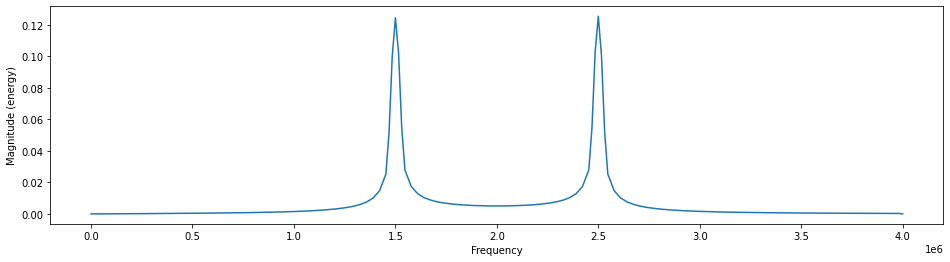

In [6]:
data = np.array([1]*32+[-1]*32)
ts, sig = rf_mod(data, 1e6)

# adjusting ps appears to shift the whole signal, but doesn't affect amplitude of demodulated signal
ts, i, q = rf_demod(sig)

plt.figure(figsize=(16,4))
plt.magnitude_spectrum(i, Fs=F_ADC)
plt.show()

Instead of doing image rejection (frequencies around $f_{LO}-f_{intermediate}$) on the analog side, we can actually do it in digital! For our desired signal, the Q signal ends up -90° from I. For the image signal, the Q signal ends up +90° from I. By applying a 90° phase-shift (Hilbert) filter in the right direction and adding to the other I/Q signal, we can filter out the image from both I and Q!

Note we don't need to generate image rejected I and Q signals, just one.

In [7]:
def image_reject(I, Q):
    I_shift = signal.hilbert(I).imag
    Q_shift = signal.hilbert(Q).imag
    
    # high probability of mixing these up in implementation, testbench heavily
    I = I + Q_shift
    Q = Q - I_shift
    
    # TODO discretize and design causal filters (should be same for both)
    
    return I, Q

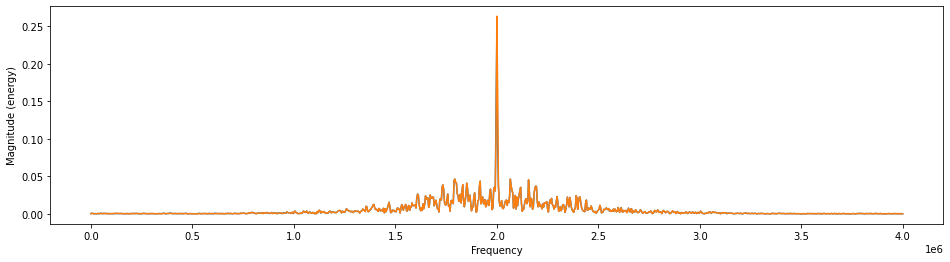

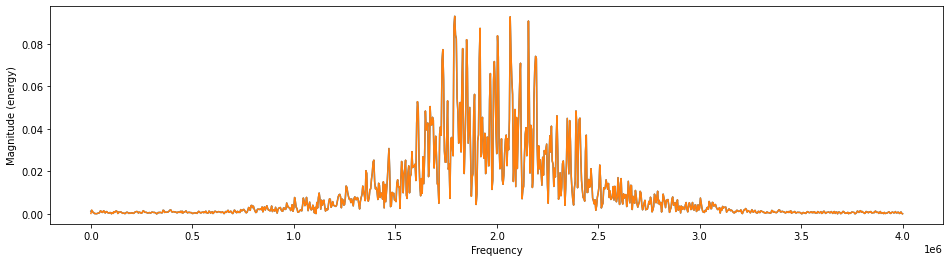

In [8]:
ts, sig = rf_mod(2*np.random.rand(256)-1,1e6)

# add hella noise at image frequency
sig += np.sin(2*np.pi*(F_CR-2*F_IF)*ts)

# demod
ts, I, Q = rf_demod(sig, ps=0)

plt.figure(figsize=(16,4))
plt.magnitude_spectrum(I, Fs=F_ADC)
plt.magnitude_spectrum(Q, Fs=F_ADC)
plt.show()

# image reject
I, Q = image_reject(I, Q)

plt.figure(figsize=(16,4))
plt.magnitude_spectrum(I, Fs=F_ADC)
plt.magnitude_spectrum(Q, Fs=F_ADC)
plt.show()

# BLE (Bluetooth Low Energy)

BLE uses GFSK with a modulation index between $h=0.45$ and $h=0.55$ and bitrate of 1Mbps which gives a frequency deviation between 225kHz and 275kHz. We use $h=0.5$ and an IF of 2MHz so transmit 0s at 1.75MHz and 2.25MHz. The spec says deviation only needs to be above 185kHz ($h=0.37$) so we should make sure our bandpass filters are relatively wide.

In [9]:
# Constants
F_BR  = 1e6   # 1Mbps
F_DEV = 250e3 # 250kHz

F_DAC = 32 * F_BR

To send data, we send each byte LSB bit first to form a (NRZ) bitstream. We upsample that and Gaussian filter before indexing into the LUT for frequency offsets.

In [10]:
def gfsk_mod(data):
    # constants
    samples_per_bit = int(F_DAC/F_BR)
    sdev = F_DEV/F_DF # signal level for 250kHz frequency deviation
    
    # convert to bitstream, NRZ array, upsample
    bs = bitarray.bitarray(endian='little')
    bs.frombytes(data)
    bs = np.array([sdev if b else -sdev for b in bs])
    bs = np.kron(bs, np.ones(samples_per_bit))
    
    # Gaussian filter
    # sigma for BT from https://www.mathworks.com/help/signal/ref/gaussdesign.html
    BT = 0.5
    sigma = np.sqrt(np.log(2))/(2*np.pi*BT) * samples_per_bit # scale to sample rate!!!
    bs = ndimage.gaussian_filter1d(bs, sigma, mode='nearest')
    
    # TODO design a causal FIR Gaussian filter and use LUT for frequency selection
    
    # modulate bitstream
    ts, sig = rf_mod(bs, F_DAC)
    return ts, sig

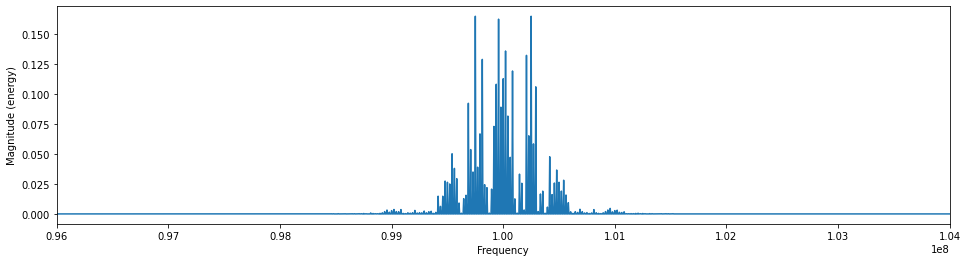

In [11]:
data = b'\xff\x33\xaa\xcc\x55\x00'*8
ts, sig = gfsk_mod(data)

plt.figure(figsize=(16,4))
plt.magnitude_spectrum(sig, Fs=FS_CR)
plt.xlim([F_CR-4e6, F_CR+4e6]) # adjacent channels are 2MHz away
plt.show()

To receive data, we mix the signal to IF to form I/Q signals. Then we perform image rejection to remove noise at the image frequency. Then we bandpass filter around the frequencies for each bit, envelope detect (square and LPF), and substract to generate the oversampled bitstream. Finally, this is handed off to the baseband side to synchronize a PLL and parse out packets.

Note this is exactly the algorithm learned in EE123 for AFSK demodulation. We ended up using a similar but better method which uses matched filters and an improved CDR (basically what the PLL did) implementation.

In [12]:
def gfsk_demod(sig, ps=0):
    # grab I/Q signals from analog RF and image reject
    ts, I, Q = rf_demod(sig, ps=ps)
    I, Q = image_reject(I, Q)
    
    # can process either I/Q (trying some combination of both appears to be same)
    sig = I
    
    # bandpass filter around each bit (pretty wide filter actually)
    bpf0_b, bpf0_a = signal.butter(2, [F_IF-F_DF, F_IF], btype='bandpass', fs=F_ADC)
    bpf1_b, bpf1_a = signal.butter(2, [F_IF, F_IF+F_DF], btype='bandpass', fs=F_ADC)
    sig0 = signal.filtfilt(bpf0_b, bpf0_a, sig)
    sig1 = signal.filtfilt(bpf1_b, bpf1_a, sig)
    
    # envelope detect
    lpf_b, lpf_a = signal.butter(2, F_IF, fs=F_ADC)
    sig0 = sig0**2 # key! shifts to DC and 2*F_IF
    sig1 = sig1**2
    sig0 = signal.filtfilt(lpf_b, lpf_a, sig0)
    sig1 = signal.filtfilt(lpf_b, lpf_a, sig1)
    
    # subtract
    sig = sig1 - sig0
    
    # TODO discretize everything and design actual filters (currently no phase shift bc not causal)
    
    return ts, sig

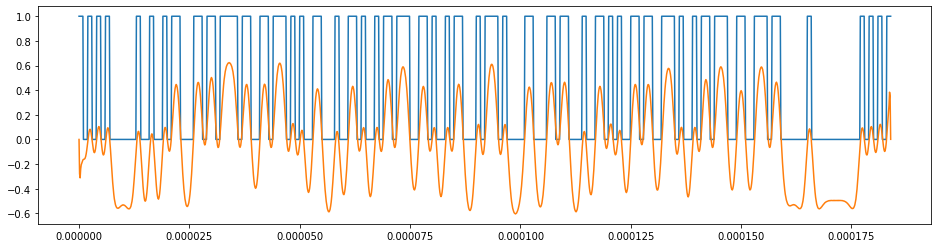

In [13]:
data = b'\x55 ilovedigitaldesign \x00\xaa'
ts, sig = gfsk_mod(data)

ts, bits = gfsk_demod(sig, ps=0)

# plot bits too (should have zero crossing on either side of a bit)
bs = bitarray.bitarray(endian='little')
bs.frombytes(data)
bs = np.array([b for b in bs])
bs = np.kron(bs, np.ones(int(F_ADC/F_BR)))

plt.figure(figsize=(16,4))
# plt.magnitude_spectrum(bits, Fs=F_ADC)
plt.plot(ts, bs)
plt.plot(ts, bits)
plt.show()

# IEEE 802.15.4

Solid resource: https://scdn.rohde-schwarz.com/ur/pws/dl_downloads/dl_application/application_notes/1gp105/1GP105_1E_Generation_of_IEEE_802154_Signals.pdf

IEEE 802.15.4 uses O-QPSK with half-sine pulse shaping. The binary data is converted to 2-bit O-QPSK symbols by converting every 4 bits to a symbol, each symbol to a pseudorandom 32 "chip" sequence, and every 2 chips to 1 O-QPSK symbol. The result is transmitting at 1MSym/s. Note that the chip rate (and maximum rate of phase changes) is 2MHz.

For parsing packets, the sequences are nearly orthogonal so we determine the symbol as the one with the smallest Hamming distance. Note that each sequence is either a conjugate or cyclic shift of another. Synchronizing to this shift can be done by looking for the preamble.

[Mathematically](https://dsp.stackexchange.com/questions/33856/the-difference-between-msk-as-cpfsk-and-oqpsk), O-QPSK with half-sine pulse shaping is equivalent to MSK (2Mbps with frequency deviation of 500kHz). With O-QPSK, we modulate even chips $c_0,c_2,\dots,c_{30}$ onto the I carrier and odd chips $c_1,c_3,\dots,c_{31}$ onto the Q carrier. Instead of changing both I and Q every $1\mu s$, every $T_c=0.5\mu s$ we change either the I or Q chip. To convert this to MSK, we take the same offset I/Q bitstreams and for even clock intervals let $k=I\oplus Q$ and for odd clock intervals let $k=\neg(I\oplus Q)$. Transmit at +500kHz for $k=1$ and -500kHz for $k=0$.

Mesri's paper and the paper it references talking about how to implement O-QPSK as MSK appear to differ in the definition of even and odd clock intervals (it is quite confusing). The only difference this makes is inverting the direction of frequency modulation which shouldn't matter once processed by the baseband. Based on further simulation, it appears that Mesri's definition is correct.

For terminology used in other notebooks and the RTL, we split each 8-bit byte into 2 4-bit symbols which are converted into 2 32-chip sequences which are then MSK-encoded for output.

In [14]:
# Constants
F_SR  = 1e6  # 1MSym/s

In [15]:
def oqpsk_mod(data):
    # convert to bitstream
    bs = bitarray.bitarray(endian='little')
    bs.frombytes(data)
    
    # arbitrarily start at 0 for Q
    msk_data = np.zeros(len(bs)+1)
    I, Q = 0, 0
    for i, b in enumerate(bs):
        if i%2==0:
            I = b
            k = not (I^Q)
        else:
            Q = b
            k = (I^Q)
        msk_data[i] = +1 if k else -1
    msk_data[-1] = msk_data[-2] # transmit last bit for a full symbol period
    
    # modulate bitstream
    ts, sig = rf_mod(msk_data, 2*F_SR)
    return ts, sig

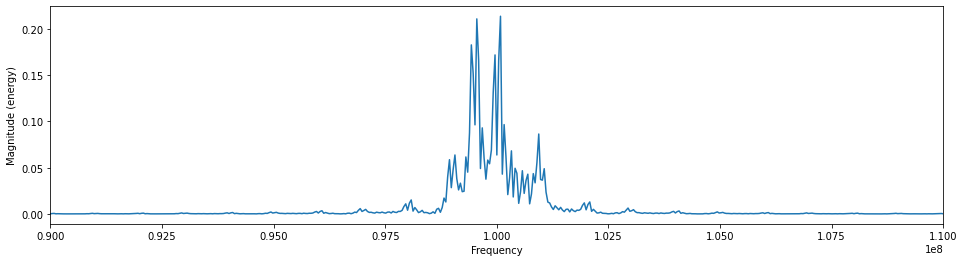

In [16]:
ts, ys = oqpsk_mod(b'\xff\x33\xaa\xcc\x55\x00')

# channels have bandwidth of 2MHz and are 5MHz apart
plt.figure(figsize=(16,4))
plt.magnitude_spectrum(ys, Fs=FS_CR)
plt.xlim([F_CR-10e6,F_CR+10e6])
plt.show()

Demodulation isn't quite as simple as low-pass filtering the I/Q signals as with normal QPSK. Instead, we can use an MSK demodulator. Essentially, we are sampling a 2Mbps chip stream. We proceed in the exact same way except now the bandpass filters (again we actually used matched filters later on) are a bit wider bc of the 500kHz deviation and envelope detection must cutoff above 2MHz.

In [17]:
def oqpsk_demod(sig, ps=0):
    # grab I/Q signals from analog RF and image reject
    ts, I, Q = rf_demod(sig, ps=ps)
    I, Q = image_reject(I, Q)
    
    # can process either I/Q (trying some combination of both appears to be same)
    sig = I
    
    # bandpass filter around each bit (pretty wide filter actually)
    bpf0_b, bpf0_a = signal.butter(2, [1e6, 2e6], btype='bandpass', fs=F_ADC)
    bpf1_b, bpf1_a = signal.butter(2, [2e6, 3e6], btype='bandpass', fs=F_ADC)
    sig0 = signal.filtfilt(bpf0_b, bpf0_a, sig)
    sig1 = signal.filtfilt(bpf1_b, bpf1_a, sig)
    
    # envelope detect
    lpf_b, lpf_a = signal.butter(2, 1.5*F_IF, fs=F_ADC)
    sig0 = sig0**2
    sig1 = sig1**2
    sig0 = signal.filtfilt(lpf_b, lpf_a, sig0)
    sig1 = signal.filtfilt(lpf_b, lpf_a, sig1)
    
    # subtract
    sig = sig1 - sig0
    
    return ts, sig

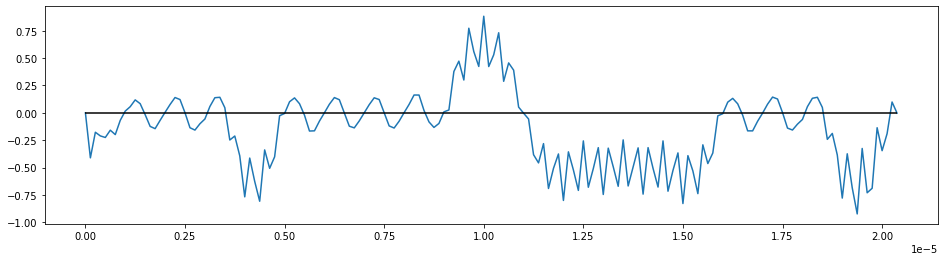

In [18]:
ts, sig = oqpsk_mod(b'\x00\xff\x27\x33\xc0')

ts, chips = oqpsk_demod(sig, ps=0)

plt.figure(figsize=(16,4))
plt.plot(ts, chips)
plt.hlines(0, 0, ts[-1], colors='black')
plt.show()

Below is a demonstration that O-QPSK w/ HSS is indeed the same as MSK.

In [19]:
def rf_iq_mod(I, Q, fs, ps=0):
    # upsample
    n_samples = int(len(I)*FS_CR/fs)
    I = np.kron(I, np.ones(n_samples//len(I)))
    Q = np.kron(Q, np.ones(n_samples//len(Q)))
    
    # generate LO
    dt = 1/FS_CR
    ts = np.r_[0:n_samples]*dt
    I_LO = np.sin(2*np.pi*F_CR*ts - ps)
    Q_LO = np.sin(2*np.pi*F_CR*ts - np.pi/2 - ps)
    
    # mix
    sig = I*I_LO + Q*Q_LO
    
    return ts, sig

def oqpsk_iq_mod(data, ps=0):
    # convert to bitstream
    bs = bitarray.bitarray(endian='little')
    bs.frombytes(data)

    # parse I/Q chips
    I = 2*np.array(list(bs[::2]))-1
    Q = 2*np.array(list(bs[1::2]))-1
    
    # half-sine shape filter each bit (and upsample)
    spc = 32
    hss = np.sin(np.linspace(0, np.pi, num=spc))
    I = np.kron(I, hss)
    Q = np.kron(Q, hss)
    
    # the Offset in O-QPSK
    I = np.hstack((I, np.zeros(spc//2)))
    Q = np.hstack((np.zeros(spc//2), Q))
    
    # modulate!
    ts, sig = rf_iq_mod(I, Q, spc*F_SR, ps=ps)
    return ts, sig

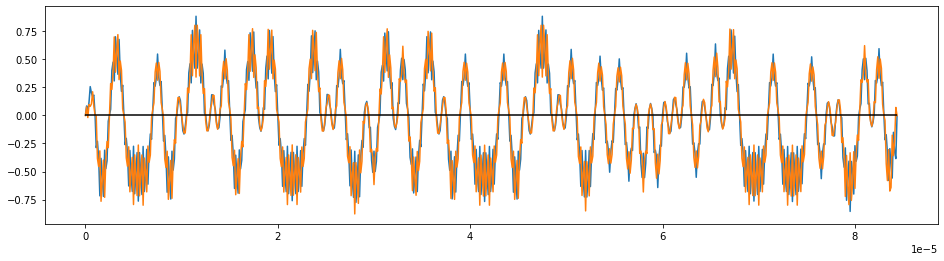

In [20]:
data = b'msk is oqpsk w/ hss?!'

ts, sig_iq = oqpsk_iq_mod(data)
ts, sig    = oqpsk_mod(data)

ts, chips_iq = oqpsk_demod(sig_iq, ps=0)
ts, chips    = oqpsk_demod(sig, ps=0)

plt.figure(figsize=(16,4))
plt.plot(ts, chips_iq)
plt.plot(ts, chips)
plt.hlines(0, 0, ts[-1], colors='black')
plt.show()